In [54]:
!pip install -q umap-learn

from typing import Dict
import torch
import torch.nn.functional as F
import argparse
import pandas as pd
import numpy as np
import logging
import random
import librosa
from torch import Tensor
from pathlib import Path
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import umap.umap_ as umap


from hp import hp

%cd /content/drive/MyDrive/Research/TAVA/TAVA-NN/codebase/paralang-vc

/content/drive/MyDrive/Research/TAVA/TAVA-NN/codebase/paralang-vc


In [52]:
# Get speaker folders (only directories with numeric names)
spk_out_path = Path(hp.speaker_embedding_dir)
sse_dict_path = 'SSE_dict.pickle'

if (spk_out_path/f"{sse_dict_path}").is_file():
  # Load data (deserialize)
  with open(spk_out_path/f"{sse_dict_path}", 'rb') as handle:
    spk_dict = pickle.load(handle)
  print(f'embedding dictionary loaded from {sse_dict_path}')
else:
  #gather speakers
  spk_folders = []
  for path in sorted(list(spk_out_path.iterdir())):
      if path.is_dir():
          if path.parts[-1].isnumeric():
              spk_folders.append(path)
  print(f"[DATA] Found a total of {len(spk_folders)} speakers")
  spk_dict = {}
  for spk in spk_folders:
      s = spk.stem
      print(s)
      embs = [torch.load(path) for path in spk.iterdir()]
      spk_dict[s] = torch.stack(embs, dim=0)
  # Store data (serialize)
  with open(spk_out_path/f"{sse_dict_path}", 'wb') as handle:
    pickle.dump(spk_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print(f'embedding dictionary saved: {sse_dict_path}')

embedding dictionary loaded from SSE_dict.pickle


In [94]:
print("Embeddings for umap gathered, computing transform.")
seed = 0

# reduce data
# def project_umap(spk_dict: Dict[str,Tensor], seed):
sorted_speakers = sorted(list(spk_dict.keys()))
flat_embs = torch.cat([spk_dict[k] for k in sorted_speakers], dim=0).numpy()
data = StandardScaler().fit_transform(flat_embs)
reducer = umap.UMAP(metric='cosine', verbose=True, n_neighbors=20, random_state=seed)
reduced_data = reducer.fit_transform(data)
spk_id = np.concatenate([np.tile(int(k), (len(spk_dict[k]),1)) for k in sorted_speakers], axis=0)
data = np.hstack((reduced_data,spk_id))
column_values = ['c1', 'c2', 'spk']
df_ = pd.DataFrame(data = data, columns = column_values)

Embeddings for umap gathered, computing transform.
UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=20, random_state=0, verbose=True)
Sat Feb 25 01:49:38 2023 Construct fuzzy simplicial set
Sat Feb 25 01:49:42 2023 Finding Nearest Neighbors
Sat Feb 25 01:49:42 2023 Finished Nearest Neighbor Search
Sat Feb 25 01:49:42 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Feb 25 01:49:47 2023 Finished embedding


In [95]:
df1 = df_.loc[(df_['spk'] < 21)]
df2 = df_.loc[(df_['spk'] >= 21) & (df_['spk'] < 35)]
df3 = df_.loc[(df_['spk'] >= 35)]

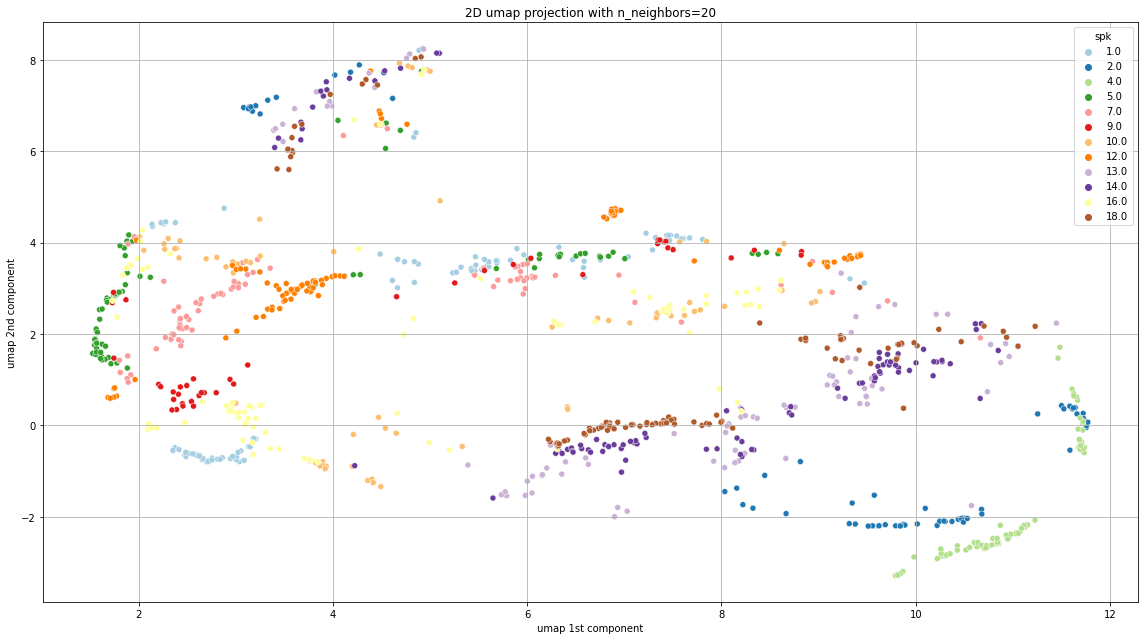

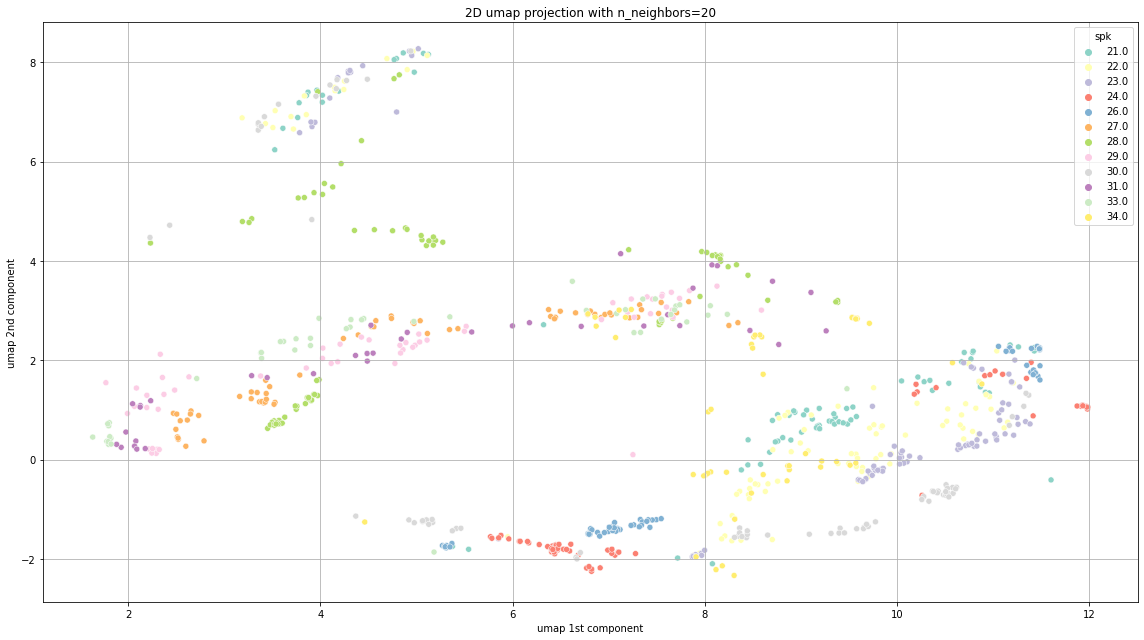

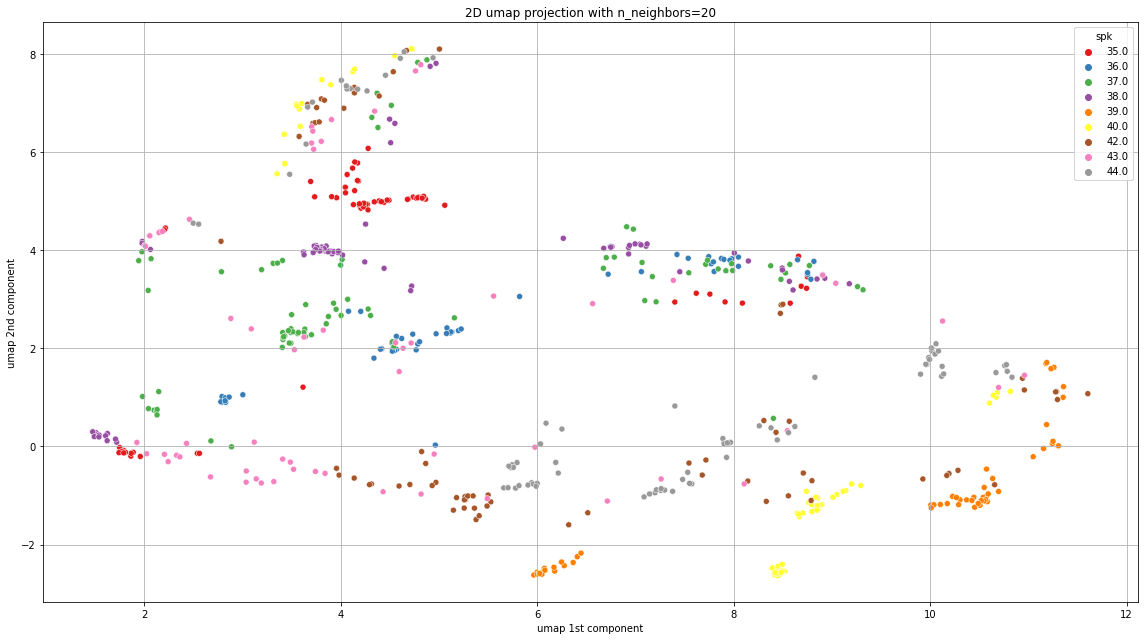

In [98]:
# plot
import seaborn as sns

qualitative_colors = sns.color_palette("Paired", 12)
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x="c1", y="c2", hue="spk", palette=qualitative_colors, legend="full")
plt.xlabel('umap 1st component')
plt.ylabel('umap 2nd component')
plt.title("2D umap projection with n_neighbors=20")
plt.grid()
plt.tight_layout()
plt.show()

qualitative_colors = sns.color_palette("Set3", 12)
plt.figure(figsize=(16,9))
sns.scatterplot(data=df2, x="c1", y="c2", hue="spk", palette=qualitative_colors, legend="full")
plt.xlabel('umap 1st component')
plt.ylabel('umap 2nd component')
plt.title("2D umap projection with n_neighbors=20")
plt.grid()
plt.tight_layout()
plt.show()

qualitative_colors = sns.color_palette("Set1", 9)
plt.figure(figsize=(16,9))
sns.scatterplot(data=df3, x="c1", y="c2", hue="spk", palette=qualitative_colors, legend="full")
plt.xlabel('umap 1st component')
plt.ylabel('umap 2nd component')
plt.title("2D umap projection with n_neighbors=20")
plt.grid()
plt.tight_layout()
plt.show()